# Preparation of Molecular-dynamics Simulations of Protein Crystals

$\text{David Wych}^{1,2}, \text{Michael E. Wall}^{1}$

1. Computer, Computational and Statistical Sciences Division, Los Alamos National Laboratory, Los Alamos, NM 87545, USA
2. Center for Nonlinear Studies, Los Alamos National Laboratory, Los Alamos, NM 87545, USA

In [1]:
import cctbx
import iotbx.pdb
import numpy as np
import itertools
import nglview as ngl
import parmed as pmd
import subprocess

*Note: we use ```![command]``` syntax throughtout this notebook to run `[command]` as though we were running it from the command line in the directory that we launched this notebook from. Other commands are `python` code that you can interpret as being run from short `python` scripts.*

*Also Note: if you try to run this whole notebook using `Kernel > Restart & Run All` or `Cell > Run All` or something similar in the menu bar above, not that the `nglview` widgets will not show the visualizations until the kernel is interrupted, or until every code block has run. If the `nglview` widgets are empty or haven't spawned a window, make sure that no other code block is running, and run those code block again.*

### Preparing a structural model: missing atoms and residues

The protein we're going to be working with is *staphylococcal nuclease*, a protein that digests single stranded nucleic acids. 

The structure for *staph. nuclease* were going to use is the PDB structure with pdbid `4WOR`.

This structure has a calcium ion and a ligand (thymidine-3'-5'-diphosphate or "pdTp") bound to the active site. 

You can explore the structure in the window below (and all the `ngl` Widgets we produce in this script) The secondary structure of the protein is shown in the ribbon diagram, the full atomic structure is shown in a semi-transparent ball-and-stick representation. The pdTp and calcium are shown in ball and stick. 

We encourage you to explore them, to see what the code has accomplished at each step along the way. You can zoom in and out, and move the structure around by pressing `ctrl` (or holding down right-click on the mouse) and dragging.

In [2]:
view = ngl.show_structure_file("./files/4wor.pdb")
view.clear_representations()
view.add_cartoon("protein")
view.add_ball_and_stick("not protein and not water")
view.add_licorice("protein", opacity=0.3)
view

NGLWidget()

That is a representation of the **coordinates** of all the atoms, contained in the `.pdb` file, but in order to simulate the protein using Molecular Dynamics (MD) we're going to need to give those atoms **properties**, like mass, charge, and van der Waals radii, and bonded properties like bond stiffness and dihedral angle constraints, etc. 

### Forcefields: choices and parametrization

The aforementioned properties are determined by the "forcefield", which is a name given the full set of parameters describing the preperties of the atoms.

The force field we're going to use for the protein is the `Amber99SB-ildn` force field. This force field also comes bundled with the `tip3p` parameter set for the waters and parameters for ions, like the calcium in the active site.

We are going to have to parameterize the pdTp molecule separately.

Let's separate out the pdTp atoms, so that we can deal with them separately.

In [3]:
# read the full structure file
with open("./files/4wor.pdb", 'r') as input_file:
    # open up another .pdb file to write to (for the protein + Ca ion)
    with open("protein_calcium.pdb", 'w') as output_file_prot:
        # ... and another for the pdTp molecule
        with open("pdTp.pdb", 'w') as output_file_pdTp:
            lines = input_file.readlines()                
            for line in lines:
                # ignore CONECT records
                if line[:6] != "CONECT":
                    # the resname for the pdTp molecule is "THP"
                    if line[:6] == "HETATM" and "THP" in line:
                        output_file_pdTp.write(line)
                    else:
                        # write everyting else but the waters to the protein
                        # and calcium .pdb file
                        if not "HOH" in line:
                            output_file_prot.write(line)

The ligand is a molecule of **thymidine-3',5'-diphosphate**, also known as **"pdTp"**, which acts as an inhibitor to the protein's normal substrate, which is single stranded DNA/RNA.

In [4]:
view = ngl.show_structure_file("pdTp.pdb")
view

NGLWidget()

A few things make parametrization of arbitrary small molecules difficult:

- Chemistry is difficult.
    - For that reason, things like $\text{pK}_a$ / protonation states and molecular geometry -- even things like bond order and connectivity -- are hard to predict, just starting from scratch, given a molecule's coordinates.
- Quantum mechanics (QM) is also difficult, but we need to do QM to get things truly right.
    - E.g. to get the partial charges of the atoms, we need to know how the electrons are distributed around the molecule, which comes down (ultimately) to quantum mechanics.

Thankfully, smart people have found workarounds.

There are a variety of ways to parametrize a small molecule, but this task is so important and so common that there exist webservers that will do it for you!

We used the webserver [SwissParam](https://swissparam.ch) to generate all the files present in the `pdTp/` directory that accompanies this notebook (after first adding hydrogens with UCSF `Chimera`'s `Structure Editing > AddH` tool, and then saving the coordinates out to a `.mol2` format, which the SwissParam server requires).

You can also attempt to parametrize small-molecules yourself. This can be accomplished with `ambertools`' `tleap`, `parmchk2` and `antechamber` packages, as shown in [this fabulous tutorial](https://ambermd.org/tutorials/basic/tutorial4b/index.php) from the AMBER website).

Next we're going to process the protein and calcium atoms with `pdb4amber`, which adds on atoms that might be missing from residues, and caps off the N- and C-termini (given the flag `--add-missing-atoms`).

Note that if the structure is missing _residues_, you'll need to add them. This can be accomplished with homology modelling, or by adding residues in some other principled fashion, as we discuss in the accompanying paper.

In [5]:
!pdb4amber -i protein_calcium.pdb -o protein_calcium_amber.pdb --add-missing-atoms
!mkdir pdb4amber_files; mv protein_calcium_amber_* pdb4amber_files


Summary of pdb4amber for: protein_calcium.pdb
/Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/lib/python3.10/site-packages/parmed/formats/pdb.py:763: PDBWarning: Could not find link atoms AtomLookupKey(name='CA', number=None, residue_name='CA', residue_number='201', chain='A', insertion_code='', segment_id='', alternate_location=None) and AtomLookupKey(name='O6P', number=None, residue_name='THP', residue_number='202', chain='A', insertion_code='', segment_id='', alternate_location=None)
  warnings.warn('Could not find link atoms %s and %s' % (key1, key2), PDBWarning)

----------Chains
The following (original) chains have been found:
A

---------- Alternate Locations (Original Residues!))

The following residues had alternate locations:
None
-----------Non-standard-resnames


---------- Missing heavy atom(s)

LYS_1 misses 4 heavy atom(s)
HIS_3 misses 5 heavy atom(s)
LYS_23 misses 3 heavy atom(s)
GLN_25 misses 4 heavy atom(s)
LYS_40 misses 5 heavy atom(s)
HIS_41 misses 

Then we're going to use `GROMACS`'s `pdb2gmx` to generate a topology file for the protein and calcium file, using, in this case, `Amber99sb-ildn` forcefield, and making sure that the parameters for the water come along with. The flag ignh makes sure that gromacs ignores any hygrogens that might be in the file, and places in hydrogens of its own (just to make sure `GROMACS` stays happy).

In [6]:
%%capture
!gmx pdb2gmx -f protein_calcium_amber.pdb -o protein_calcium_gmx.pdb -p protein.top --water spce --ff amber99sb-ildn -ignh

Now, we need to concatenate the protein and calcium structure with the structure of the ligand.

We make sure that the structure file for the full assymetric unit has all the header information from `4wor.pdb` (so that we can use `cctbx` to build the unit cell and supercell correctly, as we'll discuss shortly).

Here's what the code below accomplishes: 
- We want to ignore all the waters when we stitch things together. We're going to want the MD to infer the water structure, so we don't want to include the crystallographic waters from the start.
- The SwissParam server outputted a `.pdb` file where `ATOM` record has its element column set to `LIG` rather than the chemical element of the corresponding atom. This needs to get fixed. So we set the element column elements individually, according to the atomtype column.
- The pdTp molecule has residue number 1, even though we want it to be in the same chain (A) as the protein, which already has a residue with residue number 1. If we don't fix this, the software will think all of the atoms with residue number 1 in the same chain are in the same residue. We need to fix this. So we give it the resid 301.
- Additionally, the `.pdb` file produced by `GROMACS` above is missing characters in the element column for every hydrogen atom (though the non-hydrogens have the correct characters in the element column). We need to fix this to get `cctbx` to process the file correctly. 
- Every atom is also missing a chain ID. We need to add them back in.
- The separate molecules are missing `TER` records that distinguish them as separate molecules, to the software. 

These edits are necessary to ensure that `cctbx`/`GROMACS` etc. will be able to read and process the file properly.

In [7]:
with open("protein_calcium_gmx.pdb", 'r') as input_prot:
    with open("./files/4wor.pdb", 'r') as input_header:
        with open("pdTp/pdTp.pdb", 'r') as input_pdTp:
            with open("asymmetric_unit.pdb", 'w') as output_file:
                # store the header lines containing the "CRYST1" and "SCALE" records
                # needed for cctbx laters
                header_lines = [line for line in input_header.readlines() if line[:5] in ["CRYST", "SCALE"]]
                # store the lines for the protein, leaving out the "TITLE" and "MODEL"
                # records at the start and the "TER" and "ENDMDL" records at the end
                prot_lines = input_prot.readlines()[2:-2]
                # storing the atoms from the pdTp file
                pdTp_lines = [line for line in input_pdTp.readlines() if "ATOM" in line]
                # write the header
                for line in header_lines:
                    output_file.write(line)
                # write the protein+calcium atoms
                for line in prot_lines:
                    # making sure no waters present
                    if not "HOH" in line:
                        # for the calcium...
                        if "CA   CA" in line:
                            # put a "TER" record before
                            output_file.write("TER\n")
                            line = line[:21] + "A" + line[22:]
                            # to continue the atom indices from here...
                            index = int(line[7:11]) + 1
                            output_file.write(line)
                        else:
                            if line[:6] in ["ATOM  ", "HETATM"]:
                                # make every atom chain A
                                line = line[:21] + "A" + line[22:]
                                # add element info for hydgens
                                if "H" in line[12:16]:
                                    line = line[:77] + "H \n"
                            output_file.write(line)
                # write the pdTp atoms
                for line in pdTp_lines:
                    # get the element
                    if "H" in line[12:16]:
                        element = "H"
                    if "N" in line[12:16]:
                        element = "N"
                    if "C" in line[12:16]:
                        element = "C"
                    if "O" in line[12:16]:
                        element = "O"
                    if "P" in line[12:16]:
                        element = "P"
                    # make the resid 301, the chain A, and write the element on the end
                    line = line[:7] + str(index) + line[11:21] + "A 301" + line[26:72] + "     {}".format(element) + " \n"
                    index += 1
                    output_file.write(line)
                output_file.write("END\n")

Now, the topology file for the supercell will be the same as the topology file for the asymmetric unit, just with 31 extra copies of the `[moleculetype]` records appended, because there will be 31 extra copies of the asymmetric unit in the supercell.

So, to convert the `protein.top` file to the `supercell.top` file, we just need to tack those lines on to the end, in order.

In [8]:
with open("protein.top", 'r') as f:
    with open("supercell.top", 'w') as g:
        lines = f.readlines()
        # there's only protein and calcium in the moleculetype
        # record for the protein.top file, so the final two
        # lines are protein and calcium
        final_lines = [line for line in lines][-2:]
        for line in lines:
            # Making sure the reference to the pdTp parms goes
            # in the right place
            if "forcefield.itp" in line:
                g.write(line)
                g.write("#include \"pdTp/pdTp.itp\" \n")
            else:
                g.write(line)
        # add LIG moleculetype to the asymetric unit
        g.write("LIG                 1\n")
        # then add 31 copies
        for _ in range(31):
            for line in final_lines:
                g.write(line)
            g.write("LIG                 1\n")

### Expanding the system using `cctbx`, using the symmetry information

Next, we construct a `cctbx` hierarchy object from the asymmetric unit `.pdb` file, and use the `crystal_symmetry` information in the `xray_structure` for `4WOR` to propagate the asymmetric unit to a unit cell.

So, we have a symmetry object for our future supercell structure, but first we have to *create the sturcture file*.

Below is a call to `propagate.py`, which constructs supercells given input of asymmetric unit (`-au`), with the `CRYST1` information necessary to perform the propagation, and the number of copies of the unit cell along each direction we want to append to create the supercell (`-x`, `-y`, and `-z`).

The script uses the `CRYST1` record to make copies of the protein and perform the space group symmetry operations necessary to fill out the unit cell, then makes copies of the unit cell and transforms them according to the unit cell vector lengths and directions. This script can tile the supercell with unit cells to an size.

In our case, $\alpha=\beta=\gamma=90^{\text{o}}$, so the unit cell vectors are simply the box lengths in the x-, y- and z-directions, but the following code will work for any unit cells, with any unit cell side lengths and angles.

![unit_cell_angles](./images/unit_cell_angles.png)

In [9]:
!python ./code/propagate.py -au asymmetric_unit.pdb -o supercell.pdb -x 2 -y 2 -z 2

Next we need to process this file to remove the chain information, and renumber the residues.

In [10]:
with open("supercell.pdb", 'r') as f:
    with open("supercell_no_chains_renumbered.pdb", 'w') as g:
        lines = f.readlines()
        current_index = 1
        # the first out of order resid is the LIG with resid 301
        bad_index = 301
        for line in lines:
            if line[:4] == "ATOM":
                # Get rid of the chainids
                line = line[:20] + "  " + line[22:]
                # Find the current inex
                index = int(line[22:26])
                # If we're in the same residue
                if index == current_index:
                    pass
                # If we've arrived at the next residue
                else:
                    # Check to see if it's the next residue in order
                    if index == current_index + 1:
                        # Reset the current index
                        current_index += 1
                        # ... but otherwise do nothing, because it's fine
                    else:
                        # If it's not the next residue in order
                        # check to see if it's the bad index and
                        # reset the current
                        if not index == bad_index:
                            bad_index = int(line[22:26])
                            current_index += 1
                            line = line[:22] + "{:>4}".format(current_index+1) + line[26:]
                        else:
                            line = line[:22] + "{:>4}".format(current_index+1) + line[26:]
                
                g.write(line)
            else:
                g.write(line)

In [11]:
view = ngl.show_structure_file("supercell_no_chains_renumbered.pdb")
view.clear_representations()
view.add_cartoon("protein")
view.add_ball_and_stick("not protein")
view.camera="orthographic"
view

NGLWidget()

### Solvent modeling

Now, we're going to use gromacs tools to solvate and neutralize the system:

`gmx solvate` adds waters to the system using pre-prepared small boxes of water that are tiled to cover the simulation box and then waters are culled if they overlap with waters already in the system.

The flags are:

`-cp` the protein structure (`.gro`) file

`-cs` the water type to tile the box with

`-p` the topology (`.top`) file

In [12]:
!gmx editconf -f supercell_no_chains_renumbered.pdb -o supercell_corrected_box.gro -box 9.6998 9.6998 12.686 -angles 90 90 90 -noc
!gmx solvate -cp supercell_corrected_box.gro -cs spc216.gro -p supercell.top -o supercell_solvated.gro

               :-) GROMACS - gmx editconf, 2022.4-conda_forge (-:

Executable:   /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/bin.SSE2/gmx
Data prefix:  /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test
Working dir:  /Users/dwych/Packages/lunus/examples/tutorials/crystalline_MD_prep
Command line:
  gmx editconf -f supercell_no_chains_renumbered.pdb -o supercell_corrected_box.gro -box 9.6998 9.6998 12.686 -angles 90 90 90 -noc

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 72480 atoms
Volume: 1193.58 nm^3, corresponds to roughly 537100 electrons
No velocities found
new box vectors :  9.700  9.700 12.686 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :1193.58               (nm^3)

GROMACS reminds you: "Scientists think they are born with logic; God forbid they should study this discipline with a history of more than two and a half millennia." (Roald Hoffmann)

               :-)

In [13]:
cell = pmd.load_file("supercell_solvated.gro")
view = ngl.show_parmed(cell)
view.clear_representations()
view.add_cartoon("protein")
view.add_ball_and_stick("water", opacity=0.5)
view.add_licorice("not protein and not water")
view.camera = "orthographic"
view

NGLWidget()

Looks good!

Notice that the proteins extend out of the box, while the waters are contained within the box.

This is a consequence of the periodic boundary conditions (PBCs). The computer treats each edge of the box as equivalent to its opposite edge, and everything that extends beyond the edge of the box is wrapped around to the inside of the other side of the box, like exiting the edge of the screen in PacMan and appearing on the other side. So, from the perspective of `GROMACS`, every atom in the system will exist within the box, just like the waters, they'll just be wrapped around according to the PBCs.

There's only one more step that we need to take care of before we start the energy minimization process: neutralizing the system with ions.

We'll do this with `gmx grompp` and `gmx genion`.

`grompp` is the `GROMACS` "pre-processor", it takes in the structure (`.gro`) and topology (`.top`) files and outputs a `.tpr` file. These files are binary run input files that we'll construct again before we head in to simulation. The reason we need one now is that `GROMACS` needs to analyze the eletrostatics of the system to place ions in an intelligent way! 

`genion` is going to replace water molecules in the system with ions, but if it places ions too close to charged atoms in the system, the system could be too high energy when we place it in to minimization.

The arguments to grompp are:

`-f`: "molecular dynamics parameter" (`.mdp`) file specifying the type of simulation (in this case, the file is really a dummy file, because we're not really simulating anything)

`-c`: the structure (.gro) file

`-p`: the topology (.top) file

`-o`: the name of the binary run input (.tpr) file

The arguments to genion are:

`-s`: the binary run input (.tpr) file

`-p`: the topology (.top) file

`-o`: the name of the output structure (.gro) file

`-neutral` specifying that we want to neutralize the system with ions

`-rmin`: allows us to reset the minimum distance between added groups (it will fail if we don't add this because it thinks the ions are too close together, but as you'll see it's fine).

In [14]:
%%capture
!gmx grompp -f mdp_files/ions.mdp -c supercell_solvated.gro -p supercell.top -o ions.tpr -maxwarn 5

In [15]:
%%capture
!echo 17 | gmx genion -s ions.tpr -p supercell.top -o supercell_solvated_neutral.gro -neutral -rmin 0.4

Let's see it:

In [16]:
cell = pmd.load_file("supercell_solvated_neutral.gro")
view = ngl.show_parmed(cell)
view.clear_representations()
view.add_cartoon("protein")
view.add_ball_and_stick("water", opacity=0.5)
view.add_spacefill("name CL")
view.add_licorice("not protein and not water")
view.camera = "orthographic"
view

NGLWidget()

### Minimization

The `.mdp` files specify the parameters for simulation. Check them out in the `mdp_files` folder.

Here's what ours looks like for minimization:

`min.mdp`

```
; Parameters describing what to do, when to stop and what to save
integrator  = steep         ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0        ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01          ; Minimization step size
nsteps      = 10000          ; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet    ; Buffered neighbor searching
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = PME       ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvdw            = 1.0       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions in all 3 dimensions
```

The important bits here are the `integrator` and `nsteps` parameters. Our selections say to do 1000 steps of minimizaiton with the steepest descent algorithm.

`gmx grompp` takes in the `.mdp` file (`-f`), the starting coordiantes file (`-c`), the topology file (`-p`) and the output file name (`-o`) which will be a (`.tpr`) file with everything necessary to run the minimization.

`gmx mdrun` runs the minimization, with the `.tpr` file as input (`-s`) and a `-deffnm` flag setting the filenames for all the output files.

In [17]:
%%capture
!gmx grompp -f mdp_files/min.mdp -c supercell_solvated_neutral.gro -p supercell.top -o min_1.tpr -maxwarn 2

In [18]:
!gmx mdrun -s min_1.tpr -deffnm min_1

                :-) GROMACS - gmx mdrun, 2022.4-conda_forge (-:

Executable:   /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/bin.SSE2/gmx
Data prefix:  /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test
Working dir:  /Users/dwych/Packages/lunus/examples/tutorials/crystalline_MD_prep
Command line:
  gmx mdrun -s min_1.tpr -deffnm min_1

Compiled SIMD: SSE2, but for this host/run SSE4.1 might be better (see log).
Reading file min_1.tpr, VERSION 2022.4-conda_forge (single precision)
Using 1 MPI thread
Using 10 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+03
   Number of steps    =        10000

step 21: One or more water molecules can not be settled.
Check for bad contacts and/or reduce the timestep if appropriate.
Wrote pdb files with previous and current coordinates

writing lowest energy coordinates.

Steepest Descents converged to Fmax < 1000 in 1561 steps
Potential Energy  = -1.7232091e+06
Maximum force     =  9.5487994e+02 o

To keep things tidy, we'll make a `minimization_1` directory (`mkdir`), into which we'll move (`mv`) all of the files from this minimizaiton (`min_1.*`).

In [19]:
!mkdir minimization_1; mv min_1.* minimization_1

Now we use `GROMACS`s `energy` function to get the potential energy for our minimization.

The `echo 11` passed to the `gmx energy` call tells `GROMACS` we want to select option 11 for the data output (the Potential). 

If you were running these commands yourself, you could just run the command from `gmx energy ...` on and you could interactively select the data output yourself to get any info you want.

In [20]:
!echo 11 | gmx energy -f minimization_1/min_1.edr -o energy_1.xvg
!mv energy_1.xvg minimization_1

                :-) GROMACS - gmx energy, 2022.4-conda_forge (-:

Executable:   /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/bin.SSE2/gmx
Data prefix:  /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test
Working dir:  /Users/dwych/Packages/lunus/examples/tutorials/crystalline_MD_prep
Command line:
  gmx energy -f minimization_1/min_1.edr -o energy_1.xvg

Opened minimization_1/min_1.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Improper-Dih. 
  5  Per.-Imp.-Dih.   6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Vir-XX          14  Vir-XY          15  Vir-XZ          16  Vi

We'll plot the data with `matplotlib`, `python`'s standard plotting software, after a bit of data processing to get everything in a python friendly format.

In [21]:
import matplotlib.pyplot as plt

In [22]:
def get_data_from_xvg(filename):
    ''' helper function for getting data from .xvg files
    '''
    with open(filename) as f:
        x = []; y = []
        for line in f.readlines():
            # ignore the header lines with first character @ or #
            if line[0] not in ["#", "@"]:
                x.append(float(line.split()[0]))
                y.append(float(line.split()[1]))
    
    return np.array(x), np.array(y)

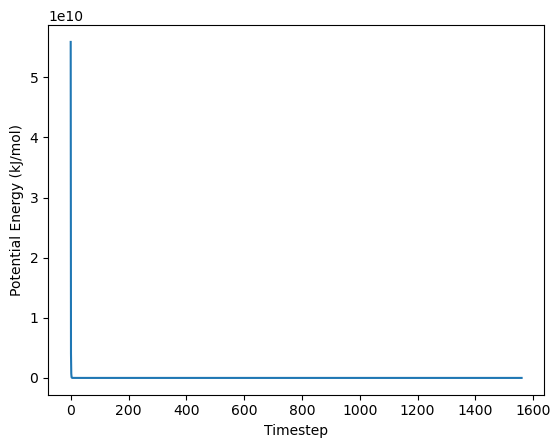

In [23]:
t, E = get_data_from_xvg("minimization_1/energy_1.xvg")
plt.plot(t, E);
plt.xlabel("Timestep");
plt.ylabel("Potential Energy (kJ/mol)");

Well, that looks funny.

What's happening here is the energy is enormous to start (note the scale on the y-axis) thanks to unfavorable interactions between the added solvent and ions and the protein, so it drops rapidly thanks to the steepest descent minimization.

To get a better sense for what's going on, we can plot things using the "symmetric log" scale for the y-axis, which converts things to the log-scale, converting nevative values (with undefined logarithm) to positive values, calculating the log, and then multiplying them by -1 again.

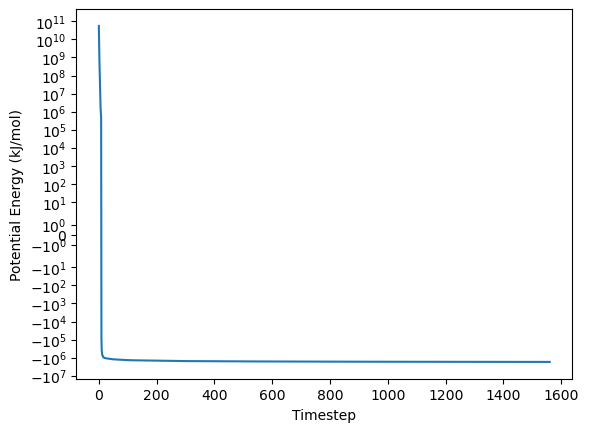

In [24]:
plt.plot(t, E);
plt.yscale("symlog")
plt.xlabel("Timestep");
plt.ylabel("Potential Energy (kJ/mol)");

This plot still isn't tremendously informative. We can see that the energy seems to plateau at somehwere around $10^{-6}$ on the log scale. But we can't really see what's happening around the plateau.

To get a better sense for what's happening in our minimization, we can plot the _absolute change_ in the energy from step to step, during minimization, on the log scale:

In [25]:
def dE(time,energy):
    ''' helper function for getting changes in energy in absolute terms
    '''
    dE = []
    for i in range(len(t)-1):
        dE.append(energy[i+1]-energy[i])
        
    return t[1:], [abs(E) for E in dE] 

Average abs change in energy for the last 50 steps: 61.255 kJ/mol


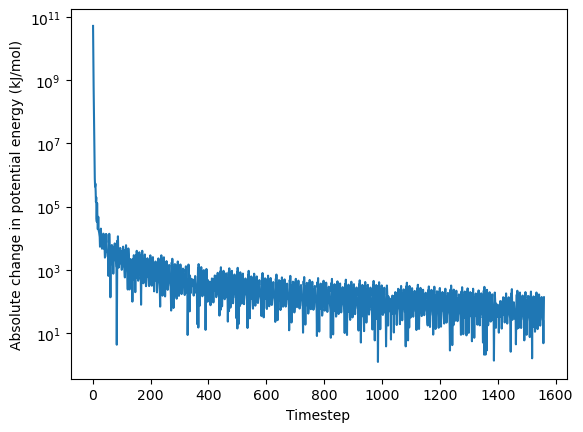

In [26]:
plt.semilogy(dE(t,E)[0], dE(t,E)[1])
plt.xlabel("Timestep");
plt.ylabel("Absolute change in potential energy (kJ/mol)");
print("Average abs change in energy for the last 50 steps: {} kJ/mol".format(np.mean(dE(t,E)[-1][-50:])))

Now, we can see that, over the course of minimization, the _changes_ in energy have plateaud to somewhere around 100 kJ/mol from step to step. As our energy plateaud somewhere on the order of -100,000 kJ/mol, these changes are somewhat inconsequential.

With the potential energy plateauing over the course of the minimization, we know we can move forward.

### Adjusting the pressure via iterative solvation and equilibration

Now we're going to do our first bits of actual molecular-dynamics simulation.

Take a look at the `equil.mdp` file in the `mdp_files` directory to see the parameters we set for this, but the important bits are:

`define = -DPOSRES`: puts restraints on the protein, ligand, and ions (all set to 1000 kJ/(moln m^2))

`integrator = md`: use the leap-frog numerical integration algorithm

`nsteps = 500`: do 500 total steps of simulation (500 steps * 0.002 fs/step = 1 ps)

`dt = 0.002`: each with a time step of 2 fs (base units are ps)

`nstxout`, `nstenergy`, etc `= 5`: sets the number of steps to wait before outputting coordinate and energy (etc.) information in their own respective files (in our case, 5 steps, so output every 10 fs (0.01 ps)

The only new argument to grompp here is the `-r` which specfifies the coordinate file to use for the target for restraints. 

Here's we'll just use the solvated, neutralized crystal structure (`supercell_solvated_neutral.gro`). 

Always be sure this file has the same number of atoms as the coordiante file. Even if the number of atoms in the actually restrained part is the same, if there's a differnt number of solvent atoms, `GROMACS` will complain.

In [27]:
%%capture
!gmx grompp -f mdp_files/equil.mdp -c minimization_1/min_1.gro -p supercell.top -r supercell_solvated_neutral.gro -o equil_1.tpr -maxwarn 2

In [28]:
!gmx mdrun -s equil_1.tpr -deffnm equil_1

                :-) GROMACS - gmx mdrun, 2022.4-conda_forge (-:

Executable:   /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/bin.SSE2/gmx
Data prefix:  /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test
Working dir:  /Users/dwych/Packages/lunus/examples/tutorials/crystalline_MD_prep
Command line:
  gmx mdrun -s equil_1.tpr -deffnm equil_1

Compiled SIMD: SSE2, but for this host/run SSE4.1 might be better (see log).
Reading file equil_1.tpr, VERSION 2022.4-conda_forge (single precision)
Changing nstlist from 10 to 100, rlist from 1 to 1.12

Using 1 MPI thread
Using 10 OpenMP threads 

starting mdrun 'Protein in water'
1000 steps,      2.0 ps.

Writing final coordinates.

               Core t (s)   Wall t (s)        (%)
       Time:      356.972       35.697     1000.0
                 (ns/day)    (hour/ns)
Performance:        4.846        4.953

GROMACS reminds you: "It is an unfortunate fact that when you raise the question of the reliability of many s

In [29]:
!mkdir equilibration_1; mv equil_1.* equilibration_1

We use `gmx energy` again, this time feeding in the selection `19` for the pressure.

In [30]:
!echo 19 | gmx energy -f equilibration_1/equil_1.edr -o equil_pressure_1.xvg
!mv equil_pressure_1.xvg equilibration_1

                :-) GROMACS - gmx energy, 2022.4-conda_forge (-:

Executable:   /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/bin.SSE2/gmx
Data prefix:  /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test
Working dir:  /Users/dwych/Packages/lunus/examples/tutorials/crystalline_MD_prep
Command line:
  gmx energy -f equilibration_1/equil_1.edr -o equil_pressure_1.xvg

Opened equilibration_1/equil_1.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Improper-Dih. 
  5  Per.-Imp.-Dih.   6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Disper.-corr.   10  Coulomb-(SR)    11  Coul.-recip.    12  Position-Rest.
 13  Potential       14  Kinetic-En.     15  Total-En

In [31]:
def get_mean_and_std_error(T,P):
    ''' helper funciton for getting the mean and standard error
    '''
    std_error = []
    mean = []
    for i in range(len(T)-1):
        mean.append(np.mean(P[:i+1]))
        std_error.append(np.std(P[:i+1])/np.sqrt(i+1))
    
    return np.array(mean), np.array(std_error)

Final Pressure Estimate: -1521.73 +/- 34.51 bar


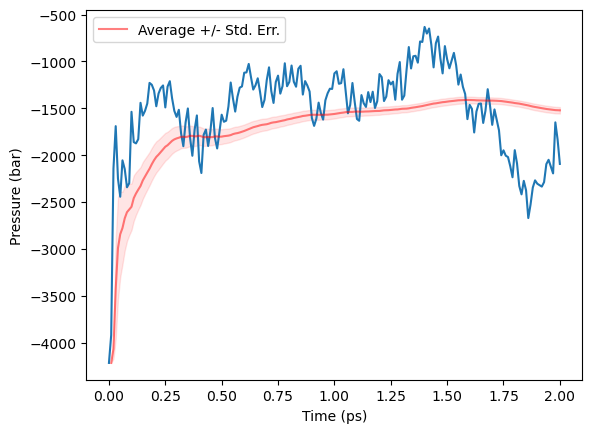

In [32]:
t, p1 = get_data_from_xvg("equilibration_1/equil_pressure_1.xvg")
mean1, std_e1 = get_mean_and_std_error(t, p1)
plt.plot(t,p1)
plt.plot(t[1:], mean1, color="Red", alpha=0.5, label="Average +/- Std. Err.")
plt.fill_between(t[1:], mean1-std_e1, mean1+std_e1, color="Red", alpha=0.1)
plt.legend()
plt.xlabel("Time (ps)")
plt.ylabel("Pressure (bar)")
print("Final Pressure Estimate: {:.2f} +/- {:.2f} bar".format(mean1[-1], std_e1[-1]))

Negative pressure! What does that even mean?

It means that there's not enough solvent. There aren't enough solvent molecules at this temperature to fill the space, so the space feels a negative pressure (it would collapse in on itself, if we didn't have periodic boundary conditions).

We need to add more solvent to bring the pressure up.

In normal simulations, we would use the NPT ensemble (constant number of particles, pressure, and temperature), keeping the pressure constant with a barostat by changing the box size (decreasing to increase pressure, increasing to decrease pressure). Here, though, we need to use the NVT ensemble, with constrant volume, becasue we need to preserve the crystallographic structure and symmetry by fixing the box size. This means we need to get the pressure up to atmospheric pressure on our own. We accomplish this by adding more waters.

### Adding additional solvent

In [33]:
!cp supercell.top supercell_2.top
!gmx solvate -cp equilibration_1/equil_1.gro -cs spc216.gro -p supercell_2.top -o supercell_solvated_neutral_2.gro

               :-) GROMACS - gmx solvate, 2022.4-conda_forge (-:

Executable:   /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/bin.SSE2/gmx
Data prefix:  /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test
Working dir:  /Users/dwych/Packages/lunus/examples/tutorials/crystalline_MD_prep
Command line:
  gmx solvate -cp equilibration_1/equil_1.gro -cs spc216.gro -p supercell_2.top -o supercell_solvated_neutral_2.gro

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input.

NOTE: From

In [34]:
%%capture
!gmx grompp -f mdp_files/min.mdp -c supercell_solvated_neutral_2.gro -p supercell_2.top -o min_2.tpr -maxwarn 2

In [35]:
!gmx mdrun -s min_2.tpr -deffnm min_2

                :-) GROMACS - gmx mdrun, 2022.4-conda_forge (-:

Executable:   /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/bin.SSE2/gmx
Data prefix:  /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test
Working dir:  /Users/dwych/Packages/lunus/examples/tutorials/crystalline_MD_prep
Command line:
  gmx mdrun -s min_2.tpr -deffnm min_2

Compiled SIMD: SSE2, but for this host/run SSE4.1 might be better (see log).
Reading file min_2.tpr, VERSION 2022.4-conda_forge (single precision)
Using 1 MPI thread
Using 10 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+03
   Number of steps    =        10000

writing lowest energy coordinates.

Steepest Descents converged to Fmax < 1000 in 1910 steps
Potential Energy  = -1.9681475e+06
Maximum force     =  9.3597192e+02 on atom 52327
Norm of force     =  1.0025433e+01

GROMACS reminds you: "Read me your scripture and I will twist it" (Red Hot Chili Peppers)



In [36]:
!mkdir minimization_2; mv min_2.* minimization_2

In [37]:
!echo 11 | gmx energy -f minimization_2/min_2.edr -o energy_2.xvg
!mv energy_2.xvg minimization_2

                :-) GROMACS - gmx energy, 2022.4-conda_forge (-:

Executable:   /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/bin.SSE2/gmx
Data prefix:  /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test
Working dir:  /Users/dwych/Packages/lunus/examples/tutorials/crystalline_MD_prep
Command line:
  gmx energy -f minimization_2/min_2.edr -o energy_2.xvg

Opened minimization_2/min_2.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Improper-Dih. 
  5  Per.-Imp.-Dih.   6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Vir-XX          14  Vir-XY          15  Vir-XZ          16  Vi

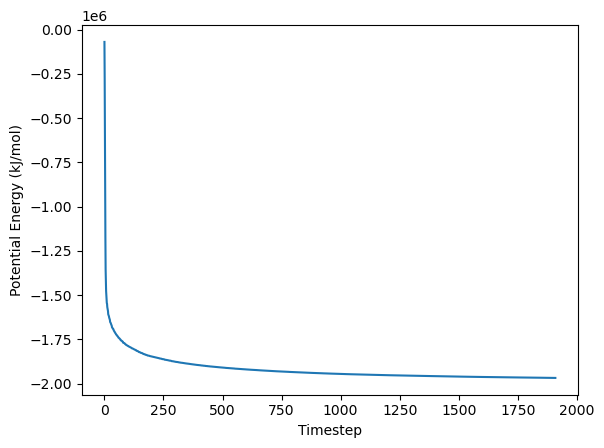

In [38]:
t, E = get_data_from_xvg("minimization_2/energy_2.xvg")
plt.plot(t, E);
plt.xlabel("Timestep");
plt.ylabel("Potential Energy (kJ/mol)");

Average abs change in energy for the last 50 steps: 22.39 kJ/mol


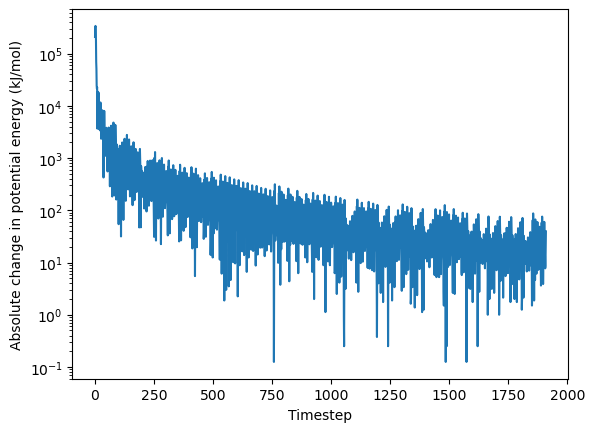

In [39]:
plt.semilogy(dE(t,E)[0], dE(t,E)[1]);
plt.xlabel("Timestep");
plt.ylabel("Absolute change in potential energy (kJ/mol)");
print("Average abs change in energy for the last 50 steps: {} kJ/mol".format(np.mean(dE(t,E)[-1][-50:])))

In [40]:
%%capture
!gmx grompp -f mdp_files/equil.mdp -c minimization_2/min_2.gro -p supercell_2.top -r supercell_solvated_neutral_2.gro -o equil_2.tpr -maxwarn 2
!gmx mdrun -s equil_2.tpr -deffnm equil_2

In [41]:
!mkdir equilibration_2; mv equil_2.* equilibration_2

In [42]:
!echo 19 | gmx energy -f equilibration_2/equil_2.edr -o equil_pressure_2.xvg
!mv equil_pressure_2.xvg equilibration_2

                :-) GROMACS - gmx energy, 2022.4-conda_forge (-:

Executable:   /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/bin.SSE2/gmx
Data prefix:  /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test
Working dir:  /Users/dwych/Packages/lunus/examples/tutorials/crystalline_MD_prep
Command line:
  gmx energy -f equilibration_2/equil_2.edr -o equil_pressure_2.xvg

Opened equilibration_2/equil_2.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Improper-Dih. 
  5  Per.-Imp.-Dih.   6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Disper.-corr.   10  Coulomb-(SR)    11  Coul.-recip.    12  Position-Rest.
 13  Potential       14  Kinetic-En.     15  Total-En

Final Pressure Estimate: 779.15 +/- 39.09 bar


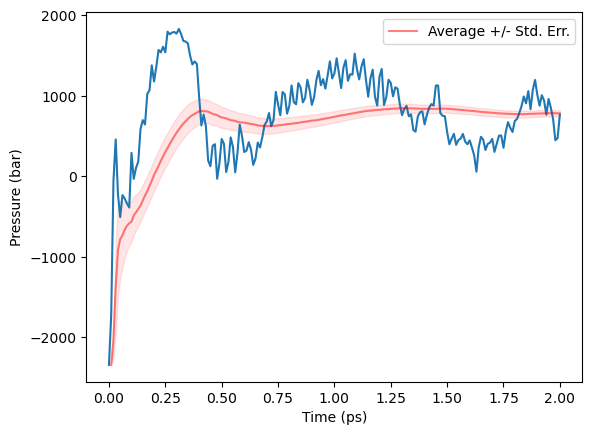

In [43]:
t, p2 = get_data_from_xvg("equilibration_2/equil_pressure_2.xvg")
mean2, std_e2 = get_mean_and_std_error(t, p2)
plt.plot(t,p2)
plt.plot(t[1:], mean2, color="Red", alpha=0.5, label="Average +/- Std. Err.")
plt.legend();
plt.fill_between(t[1:], mean2-std_e2, mean2+std_e2, color="Red", alpha=0.1)
plt.xlabel("Time (ps)");
plt.ylabel("Pressure (bar)");
print("Final Pressure Estimate: {:.2f} +/- {:.2f} bar".format(mean2[-1], std_e2[-1]))

## Now we're close!

In practice, you want longer minimizations (e.g. 5000-10,000 steps) and longer equilibrations (e.g. 10-100 ps) just to make sure everything is stable. But you can get the idea for what we're going even with these short runs.

You basically want to add or remove solvent until the pressure has reached about 1 bar, using the average pressure during successive equlibrations as a guide.

We can find an estimate for the number of waters to add to bring us to 1 bar by linear interpolation:

$P = \frac{P_{2}-P_{1}}{N_{w,2}-N_{w,1}} \ \mathrm{d}N_{w} + P_{1}$

where $dN_{w}$ is the change in the number of total waters from the starting number. 

We want to set $P$ to 1 and solve for $N_{w}$ to get an estimate for how many waters to add or subtract in our next run.

$ 1 = \frac{P_{2}-P_{1}}{N_{w,2}-N_{w,1}} \ \mathrm{d}N_{w} + P_{1} \rightarrow 1 - P_{1} = \frac{P_{2}-P_{1}}{N_{w,2}-N_{w,1}} \ \mathrm{d}N_{w} $ 

$ \mathrm{d}N_{w} = \frac{(1 - P_{1})(N_{w,2}-N_{w,1})}{(P_{2}-P_{1})} $

In our case, we added too many: if you plug in all the numbers, we get:

In [44]:
P1 = mean1[-1]
P2 = mean2[-1]

def get_num_waters(gro_file):
    with open(gro_file, 'r') as f:
        wat_atoms = 0
        for line in f.readlines():
            if "SOL" in line:
                wat_atoms += 1
                
    return int(wat_atoms/3)

Nw1 = get_num_waters("supercell_solvated_neutral.gro")
Nw2 = get_num_waters("supercell_solvated_neutral_2.gro")

dNw = int(((1-P1)*(Nw2-Nw1))/(P2-P1))

print("Total waters we need to add to the original solvated supercell: {}".format(dNw))

Total waters we need to add to the original solvated supercell: 1559


We keep doing this iterative process until the pressure +/- standard error is in the range (-100,100) bar. Then we're ready for production simulation!

In [45]:
!mv supercell_2.top equilibration_2
!cp supercell.top supercell_2.top
!gmx solvate -cp equilibration_1/equil_1.gro -cs spc216.gro -p supercell_2.top -o supercell_solvated_neutral_2.gro -maxsol {dNw}

               :-) GROMACS - gmx solvate, 2022.4-conda_forge (-:

Executable:   /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/bin.SSE2/gmx
Data prefix:  /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test
Working dir:  /Users/dwych/Packages/lunus/examples/tutorials/crystalline_MD_prep
Command line:
  gmx solvate -cp equilibration_1/equil_1.gro -cs spc216.gro -p supercell_2.top -o supercell_solvated_neutral_2.gro -maxsol 1559

Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary. Note, that this functionality may
         be removed in a future GROMACS version. Please, consider
         using another file format for your input

In [46]:
%%capture
!gmx grompp -f mdp_files/min.mdp -c supercell_solvated_neutral_2.gro -p supercell_2.top -o min_3.tpr -maxwarn 2

In [47]:
!gmx mdrun -s min_3.tpr -deffnm min_3

                :-) GROMACS - gmx mdrun, 2022.4-conda_forge (-:

Executable:   /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/bin.SSE2/gmx
Data prefix:  /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test
Working dir:  /Users/dwych/Packages/lunus/examples/tutorials/crystalline_MD_prep
Command line:
  gmx mdrun -s min_3.tpr -deffnm min_3

Compiled SIMD: SSE2, but for this host/run SSE4.1 might be better (see log).
Reading file min_3.tpr, VERSION 2022.4-conda_forge (single precision)
Using 1 MPI thread
Using 10 OpenMP threads 


Steepest Descents:
   Tolerance (Fmax)   =  1.00000e+03
   Number of steps    =        10000

writing lowest energy coordinates.

Steepest Descents converged to Fmax < 1000 in 1134 steps
Potential Energy  = -1.9131244e+06
Maximum force     =  9.9350537e+02 on atom 52327
Norm of force     =  1.3431232e+01

GROMACS reminds you: "I didn't know what MD was. I think I've managed to catch up." (Berk Hess)



In [48]:
!mkdir minimization_3; mv min_3.* minimization_3

In [49]:
!echo 11 | gmx energy -f minimization_3/min_3.edr -o energy_3.xvg
!mv energy_3.xvg minimization_3

                :-) GROMACS - gmx energy, 2022.4-conda_forge (-:

Executable:   /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/bin.SSE2/gmx
Data prefix:  /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test
Working dir:  /Users/dwych/Packages/lunus/examples/tutorials/crystalline_MD_prep
Command line:
  gmx energy -f minimization_3/min_3.edr -o energy_3.xvg

Opened minimization_3/min_3.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Improper-Dih. 
  5  Per.-Imp.-Dih.   6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pressure      
 13  Vir-XX          14  Vir-XY          15  Vir-XZ          16  Vi

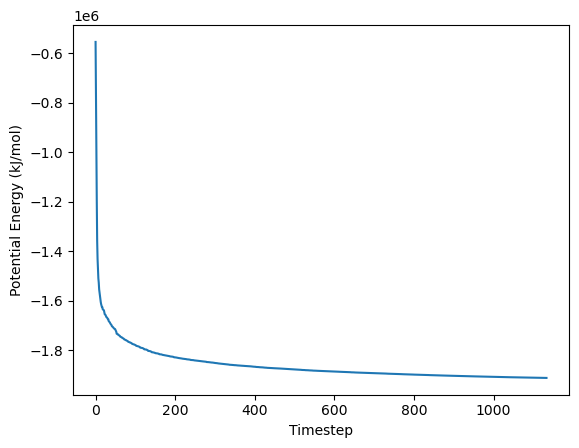

In [50]:
t, E = get_data_from_xvg("minimization_3/energy_3.xvg")
plt.plot(t, E);
plt.xlabel("Timestep");
plt.ylabel("Potential Energy (kJ/mol)");

Average abs change in energy for the last 50 steps: 36.09 kJ/mol


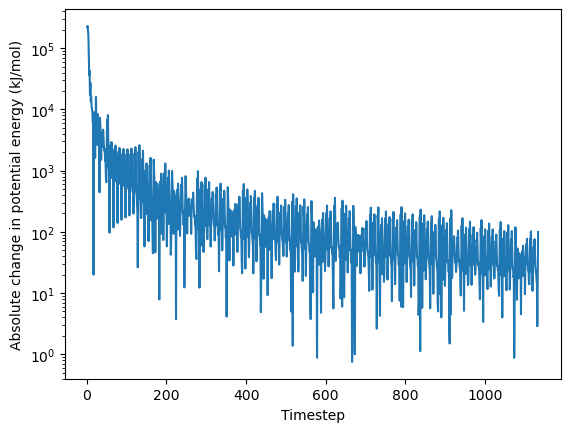

In [51]:
plt.semilogy(dE(t,E)[0], dE(t,E)[1]);
plt.xlabel("Timestep");
plt.ylabel("Absolute change in potential energy (kJ/mol)");
print("Average abs change in energy for the last 50 steps: {} kJ/mol".format(np.mean(dE(t,E)[-1][-50:])))

In [52]:
%%capture
!gmx grompp -f mdp_files/equil.mdp -c minimization_3/min_3.gro -p supercell_2.top -r supercell_solvated_neutral_2.gro -o equil_3.tpr -maxwarn 2
!gmx mdrun -s equil_3.tpr -deffnm equil_3

In [53]:
!mkdir equilibration_3; mv equil_3.* equilibration_3

In [54]:
!echo 19 | gmx energy -f equilibration_3/equil_3.edr -o equil_pressure_3.xvg
!mv equil_pressure_3.xvg equilibration_3

                :-) GROMACS - gmx energy, 2022.4-conda_forge (-:

Executable:   /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/bin.SSE2/gmx
Data prefix:  /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test
Working dir:  /Users/dwych/Packages/lunus/examples/tutorials/crystalline_MD_prep
Command line:
  gmx energy -f equilibration_3/equil_3.edr -o equil_pressure_3.xvg

Opened equilibration_3/equil_3.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Improper-Dih. 
  5  Per.-Imp.-Dih.   6  LJ-14            7  Coulomb-14       8  LJ-(SR)       
  9  Disper.-corr.   10  Coulomb-(SR)    11  Coul.-recip.    12  Position-Rest.
 13  Potential       14  Kinetic-En.     15  Total-En

Final Pressure Estimate: -30.42 +/- 43.50 bar


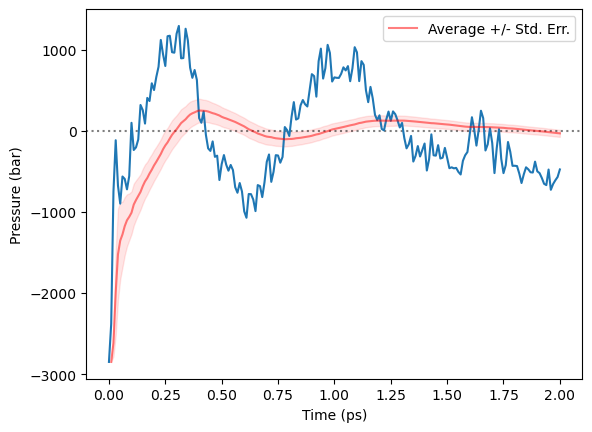

In [55]:
t, p2 = get_data_from_xvg("equilibration_3/equil_pressure_3.xvg")
mean2, std_e2 = get_mean_and_std_error(t, p2)
plt.axhline(0, ls=":",c="k",alpha=0.5)
plt.plot(t,p2)
plt.plot(t[1:], mean2, color="Red", alpha=0.5, label="Average +/- Std. Err.")
plt.legend();
plt.fill_between(t[1:], mean2-std_e2, mean2+std_e2, color="Red", alpha=0.1)
plt.xlabel("Time (ps)");
plt.ylabel("Pressure (bar)");
print("Final Pressure Estimate: {:.2f} +/- {:.2f} bar".format(mean2[-1], std_e2[-1]))

### The trajectory

gmx `trjconv` converts the `.trr` trajectory file to another `.trr` trajectory file, but with the molecules mapped back, according to the periodic boundary conditions, so that the molecules are kept whole (`-pbc mol`). Note that `gmx trjconv` can also be used to convert the trajectory to (or between) files in the `.xtc` format as well (which is compressed, and so the files are much smaller than the `.trr` file format). The `.xtc` format does not include velocities, just coordinates, whereas the `.trr` format contains both.

In [56]:
!echo 0 | gmx trjconv -f equilibration_3/equil_3.xtc -s equilibration_3/equil_3.tpr -o equil_3_mol.xtc -pbc mol
!mv equil_3_mol.xtc equilibration_3

               :-) GROMACS - gmx trjconv, 2022.4-conda_forge (-:

Executable:   /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/bin.SSE2/gmx
Data prefix:  /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test
Working dir:  /Users/dwych/Packages/lunus/examples/tutorials/crystalline_MD_prep
Command line:
  gmx trjconv -f equilibration_3/equil_3.xtc -s equilibration_3/equil_3.tpr -o equil_3_mol.xtc -pbc mol

Note that major changes are planned in future for trjconv, to improve usability and utility.
Will write xtc: Compressed trajectory (portable xdr format): xtc
Reading file equilibration_3/equil_3.tpr, VERSION 2022.4-conda_forge (single precision)
Reading file equilibration_3/equil_3.tpr, VERSION 2022.4-conda_forge (single precision)
Select group for output
Group     0 (         System) has 127035 elements
Group     1 (        Protein) has 71232 elements
Group     2 (      Protein-H) has 34944 elements
Group     3 (        C-alpha) has  4352 elements
Group   

In [57]:
import mdtraj as md
### DON'T DO THIS IN GENERAL WE JUST DON'T CARE ABOUT THE WARNINGS IN THIS CASE
import warnings
warnings.filterwarnings('ignore')
###############################################################################
traj = md.load("./equilibration_3/equil_3_mol.xtc", top="./supercell_solvated_neutral_2.gro")

In [ ]:
traj_view = ngl.show_mdtraj(traj)
traj_view.clear_representations()
traj_view.add_cartoon("protein")
traj_view.add_ball_and_stick("water", opacity=0.5)
traj_view.add_spacefill("name CL", color="yellow")
traj_view.add_point("not protein and not water and not name CL")
traj_view.camera = "orthographic"
traj_view

## Production

Now we're ready for production. We had the restraints set to the default of 1000 kJ/(mol nm^2) for all of equilibration, but for production one might want to decrease the restraint strength or eliminate the restraints entirely. To eliminate the restraints entirely, one would want to delete or comment out (with `;`) the following line in the `prod.mdp` file:

```define                  = -DPOSRES              ; position restrain the protein```

Here's why:

When `define` is set to `-DPOSRES`, `GROMACS` looks for the following statement in the `supercell_2.top` file (or the `.itp` files referenced therein -- in our case `protein_Protein.itp`):

```
; Include Position restraint file
#ifdef POSRES
#include "posre_Protein.itp"
#endif
```

This statement tells `GROMACS` to `include` the information in the file `posre_Protein.itp` for restraints.

`posre_Protein.itp` was created by `pdb2gmx`, and defines the atoms (be index) to be restrained, the restraint type, and the force constant for the restraints, in units of kJ/(mol nm^2). `pdb2gmx` defines restraints by default on all heavy atoms (which is why there are gaps in the atom indices -- the restraints are not applied to hydrogens):

```
[ position_restraints ]
; atom  type      fx      fy      fz   
     1     1  1000  1000  1000 
     5     1  1000  1000  1000 
     7     1  1000  1000  1000 
    10     1  1000  1000  1000 
    13     1  1000  1000  1000 
    ...
```

Type 1 restraints are simple harmonic restraints (the atoms are restrained to the positions in the reference structure by harmonic bonds, with the associated strengths in each direction). The reference structure is defined by the `-r` flag to `gmx grompp`, and for equilibration we've been using `supercell_solvated_neutral_2.gro`, which is the original propagated crystal structure after solvation and neutralization (before minimization). One can use any structure as a reference so long as the structure file has the same number of atoms as the system being simulated, but for crystalline MD simulations, restraints are often done with reference to the (propagated) crystal structure.

To generate a new set of restraints one can either edit the `posre_Protein.itp` file, changing 1000 to whatever restraint constant one wishes, or one can use the the built-in gromacs command `genrestr`.

In our setup here, `pdb2gmx` was used to generate the topology for the file `protein_calcium_amber.pdb` which contained only the protein and calcium ions, and then the `pdTp.itp` parameter file for the ligand was added to the full system `protein.top` file, creating the `supercell.top`, which was edited to reflect the fact that there are 32 copies of the Protein, calcium (with the `[ moleculetype ]` record `Ion2` in the topology file), and the ligand (with the `[ moleculetype ]` `LIG` in the topology file). 

The easiest way for us to generate a new set of restraints is for us to work with the same `protein_calcium_amber.pdb` file, and output a new `posre_Protein_weaker.itp` file using `gmx genrestr` (selecting only heavy atoms with the selection `Protein-H`):

In [59]:
!echo "Protein-H" | gmx genrestr -f protein_calcium_amber.pdb -o posre_Protein_weaker.itp -fc 200 200 200

               :-) GROMACS - gmx genrestr, 2022.4-conda_forge (-:

Executable:   /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test/bin.SSE2/gmx
Data prefix:  /Users/dwych/miniconda3_x86/miniconda3/envs/crystalMD_lunus_test
Working dir:  /Users/dwych/Packages/lunus/examples/tutorials/crystalline_MD_prep
Command line:
  gmx genrestr -f protein_calcium_amber.pdb -o posre_Protein_weaker.itp -fc 200 200 200


Reading structure file
Select group to position restrain
Group     0 (         System) has  2227 elements
Group     1 (        Protein) has  2226 elements
Group     2 (      Protein-H) has  1092 elements
Group     3 (        C-alpha) has   136 elements
Group     4 (       Backbone) has   408 elements
Group     5 (      MainChain) has   545 elements
Group     6 (   MainChain+Cb) has   672 elements
Group     7 (    MainChain+H) has   677 elements
Group     8 (      SideChain) has  1549 elements
Group     9 (    SideChain-H) has   547 elements
Group    10 (    Prot-Masses) 

Now the only thing left to do is edit the `.mdp` and/or `.top`/`.itp` files to use the new, weaker restraints.

If one wishes not to edit the `.mdp` file, and use the same flag for `define`, i.e.:

```define                  = -DPOSRES              ; position restrain the protein```

one simply needs to change the following section of `protein_Protein.itp` to:

```
; Include Position restraint file
#ifdef POSRES
#include "posre_Protein_weaker.itp"
#endif
```

and that's it! The new, weaker restraints will now be applied to the protein.

---

However, another option, for instance if one wishes to use different restraints at different periods of simulation, one can create new `-DPOSRES` flag(s). For example, if one uses:

```define                  = -DPOSRES_WEAKER              ; position restrain the protein more weakly```

One then needs to add the following section to the `protein_Protein.itp` file:

```
; Include Position restraint file
#ifdef POSRES
#include "posre_Protein.itp"
#endif
; Include weaker Position restraint file
#ifdef POSRES_WEAKER
#include "posre_Protein_weaker.itp"
#endif
```

Now, if one wishes to use normal-strength restraints, one can supply the parameter: `define = -DPOSRES`; but if one wishes to use the weaker restraints, one can supply the parameter: 

```define = -DPOSRES_WEAKER```

This can be useful if one wishes to apply successively weaker restraints, without having to edit the topology file each time -- simply define a variety of `#ifdef` conditions, and then call them in the `.mdp` file with the `define` parameters whenever they are appropriate.

---

Production is now carried out in the same way we carried out equilibration, but now specifying the `prod.mdp` file defining the parameteres for production simulation rather than equilibration (you can uncomment the following code block to simulate a production trajectory, but note that the equilibration was running at about 5ns on our local machines used for testing, so a 100 ns trajectory would take about 20 days to run -- to change the length of simulation, edit the `nsteps` parameter in `prod.mdp` to something more manageable, or transfer the files to a computing cluster for faster performance; the following is provided only for reference for how one would continue on to production from the end of our equilibration run).

In [ ]:
#!gmx grompp -f mdp_files/prod.mdp -c equilibration_3/equil_3.gro -p supercell_2.top -r supercell_solvated_neutral_2.gro -o prod.tpr -maxwarn 2
#!gmx mdrun -s prod.tpr -deffnm prod